In [1]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import norm
import numpy as np
import scipy as sp
import pickle

# Build figures inline
%matplotlib inline

In [2]:
# Import scikit-learn tools, vectorizers, transformer, and classifiers
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score


# import CountVectorizer and TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# import Multinomial Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB

# import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# import Logistic Regression CV Classifier
from sklearn.linear_model import LogisticRegressionCV

# import SVM classifiers
from sklearn.svm import SVC

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [3]:
with open('beerML.pickle', 'rb') as b:
    beer = pickle.load(b)

In [4]:
beer = beer.drop(['ABV', 'profileName', 'word_count', 'log_word_count'], axis=1)

In [5]:
beer.head()

,name,style,appearance,aroma,palate,taste,overall,text,clean_text_stem,clean_text_lem,3rate_appear,3rate_aroma,3rate_palate,3rate_taste,high_low
0,John Harvards Simcoe IPA,India Pale Ale (IPA),4,3,3,3,3.25,"On tap at the Springfield, PA location. Poured...",tap springfield pa location pour deep cloudi o...,tap springfield pa location pour deep cloudy o...,high,medium,medium,medium,low
1,John Harvards Simcoe IPA,India Pale Ale (IPA),4,3,4,4,3.75,On tap at the John Harvards in Springfield PA....,tap john harvard springfield pa pour rubi red ...,tap john harvard springfield pa pour ruby red ...,high,medium,high,high,high
2,John Harvards Vanilla Black Velvet Stout,Sweet Stout,5,4,4,4,4.25,"Springfield, PA location... Poured an opaque b...",springfield pa location pour opaqu black color...,springfield pa location pour opaque black colo...,high,high,high,high,high
3,John Harvards American Brown Ale,Brown Ale,4,3,3,3,3.25,"On tap at the Springfield, PA location. Listed...",tap springfield pa location list beer menu jam...,tap springfield pa location list beer menu jam...,high,medium,medium,medium,low
4,John Harvards Grand Cru,Belgian Ale,2,3,3,4,3.00,"Sampled @ the Springfield, PA location. Cand...",sampl springfield pa location candi sugar domi...,sample springfield pa location candi sugar dom...,low,medium,medium,high,low


In [6]:
beer_overall = beer.drop(['aroma','palate','taste','appearance', '3rate_aroma',
                          '3rate_palate', '3rate_taste', '3rate_appear'], axis=1)

In [7]:
beer_overall.head()

,name,style,overall,text,clean_text_stem,clean_text_lem,high_low
0,John Harvards Simcoe IPA,India Pale Ale (IPA),3.25,"On tap at the Springfield, PA location. Poured...",tap springfield pa location pour deep cloudi o...,tap springfield pa location pour deep cloudy o...,low
1,John Harvards Simcoe IPA,India Pale Ale (IPA),3.75,On tap at the John Harvards in Springfield PA....,tap john harvard springfield pa pour rubi red ...,tap john harvard springfield pa pour ruby red ...,high
2,John Harvards Vanilla Black Velvet Stout,Sweet Stout,4.25,"Springfield, PA location... Poured an opaque b...",springfield pa location pour opaqu black color...,springfield pa location pour opaque black colo...,high
3,John Harvards American Brown Ale,Brown Ale,3.25,"On tap at the Springfield, PA location. Listed...",tap springfield pa location list beer menu jam...,tap springfield pa location list beer menu jam...,low
4,John Harvards Grand Cru,Belgian Ale,3.00,"Sampled @ the Springfield, PA location. Cand...",sampl springfield pa location candi sugar domi...,sample springfield pa location candi sugar dom...,low


In [8]:
ipa = beer_overall[beer_overall['style'] == 'India Pale Ale (IPA)']
ipa.head()

,name,style,overall,text,clean_text_stem,clean_text_lem,high_low
0,John Harvards Simcoe IPA,India Pale Ale (IPA),3.25,"On tap at the Springfield, PA location. Poured...",tap springfield pa location pour deep cloudi o...,tap springfield pa location pour deep cloudy o...,low
1,John Harvards Simcoe IPA,India Pale Ale (IPA),3.75,On tap at the John Harvards in Springfield PA....,tap john harvard springfield pa pour rubi red ...,tap john harvard springfield pa pour ruby red ...,high
20,Barley Island Barfly IPA,India Pale Ale (IPA),3.75,Another quality session IPA. The lowest ABV o...,anoth qualiti session ipa lowest abv ani ipa w...,another quality session ipa low abv ipa would ...,high
21,Barley Island Barfly IPA,India Pale Ale (IPA),3.25,"Received in a trade with mmm///beer, so thanks...",receiv trade mmmbeer thank bro beer wa quit ni...,receive trade mmmbeer thank bro beer quite nic...,low
22,Barley Island Barfly IPA,India Pale Ale (IPA),3.75,bottle thanks to mmm///beer. deep ruby color ...,bottl thank mmmbeer deep rubi color finger cre...,bottle thank mmmbeer deep ruby color finger cr...,high


# Machine Learning

### Build baseline model w/ Naive Bayes

In [9]:
# Store overall beer dataset into feature matrix and response vector
X_overall = beer_overall['clean_text_lem']
y_overall = (beer_overall.high_low == 'high').values.astype(np.int)

In [10]:
# Instantiate CountVectorizer and TfidfVectorizer
vect = CountVectorizer(min_df=1, ngram_range=(1, 2)) 
tfidf_vect = TfidfVectorizer(min_df=1, ngram_range=(1, 2))

In [11]:
tfidf = TfidfVectorizer(min_df=1, ngram_range=(1, 2))

In [12]:
# Apply CountVectorizer 
X_all_C = vect.fit_transform(beer_overall.clean_text_lem.apply(str))
X_all_C = X_all_C.tocsc() 

# Apply TfidfVectorizer
X_all_idf = tfidf_vect.fit_transform(beer_overall.clean_text_lem.apply(str))
X_all_idf = X_all_idf.tocsc() 

In [13]:
# Split train/test data for all data
# This is for CountVectorizer
Xtrain_all_C, Xtest_all_C, ytrain_all_C, ytest_all_C = train_test_split(X_all_C, y_overall, random_state=17)

# This is for Tfidf Vectorizer
Xtrain_all_idf, Xtest_all_idf, ytrain_all_idf, ytest_all_idf = train_test_split(X_all_idf, y_overall, random_state=17)

In [14]:
# Instantiate MultinomialNB() for CountVectorizer
nb_overall = MultinomialNB(alpha=1, fit_prior=True)

# Train model
nb_overall.fit(Xtrain_all_C, ytrain_all_C)

# Make predictions for Xtest
y_pred_count = nb_overall.predict(Xtest_all_C)

# Calculate F1 Score
f1 = metrics.f1_score(ytest_all_C, y_pred_count)

# Confusion matrix
cm = metrics.confusion_matrix(ytest_all_C, y_pred_count)

# Calculate predicted probabilities for Xtest
y_prob_count = nb_overall.predict_proba(Xtest_all_C)[:,1]

# Calculate AUC for Naive Bayes model with CountVec
auc = metrics.roc_auc_score(ytest_all_C, y_prob_count)

print(vect)
print('\nF1 Score: ', f1)
print('\nConfusion Matrix:\n', cm)
print('\nAUC: ', auc)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

F1 Score:  0.8359566014669927

Confusion Matrix:
 [[ 5117  2874]
 [ 1420 10941]]

AUC:  0.8532420295945957


Using CountVectorizer, at baseline the Naive Bayes model correctly predicted 10941 "high" overall ratings. Likewise, 5117 were correctly predicted to be "low" overall ratings. 

However, 1420 reviews were incorrectly predicted to be "high" overall ratings and 1420 were incorrectly predicted to be "low" overall ratings.

Let's see how the TfidfVectorizer does.

In [15]:
# Instantiate multinomialNB() for TfidfVectorizer
nb_tfidf_overall = MultinomialNB(alpha=1, fit_prior=True)

# Train model
nb_tfidf_overall.fit(Xtrain_all_idf, ytrain_all_idf)

# Make predictions for Xtest1
y_pred_tfidf = nb_tfidf_overall.predict(Xtest_all_idf)

# Calculate F1 Score
f1 = metrics.f1_score(ytest_all_idf, y_pred_tfidf)

# Confusion matrix
cm = metrics.confusion_matrix(ytest_all_idf, y_pred_tfidf)

# Calculate predicted probabilities for Xtest1
y_prob_tfidf = nb_tfidf_overall.predict_proba(Xtest_all_idf)[:,1]

# Calculate AUC for Naive Bayes model with Tfidf
auc = metrics.roc_auc_score(ytest_all_idf, y_prob_tfidf)

print(tfidf_vect)
print('\nF1 Score: ', f1)
print('\nConfusion Matrix:\n', cm)
print('\nAUC: ', auc)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

F1 Score:  0.79622211366227

Confusion Matrix:
 [[ 1871  6120]
 [  137 12224]]

AUC:  0.8476943830638852


Using TfidfVectorizer at baseline, the Naive Bayes model correctly predicted 12224 "high" overall ratings and 1871 "low" overall ratings. 

However, 137 reviews were incorrectly predicted to be "high" overall ratings and 6120 for "low" overall ratings. 

This did better in predicting high overall ratings but did poorly for low ones. Parameters definitely need to be tuned.

***

### Picking Hyperparameters

I want to look at the alpha, min_df and fit_prior to see if I can make the model better.

__min_df:__

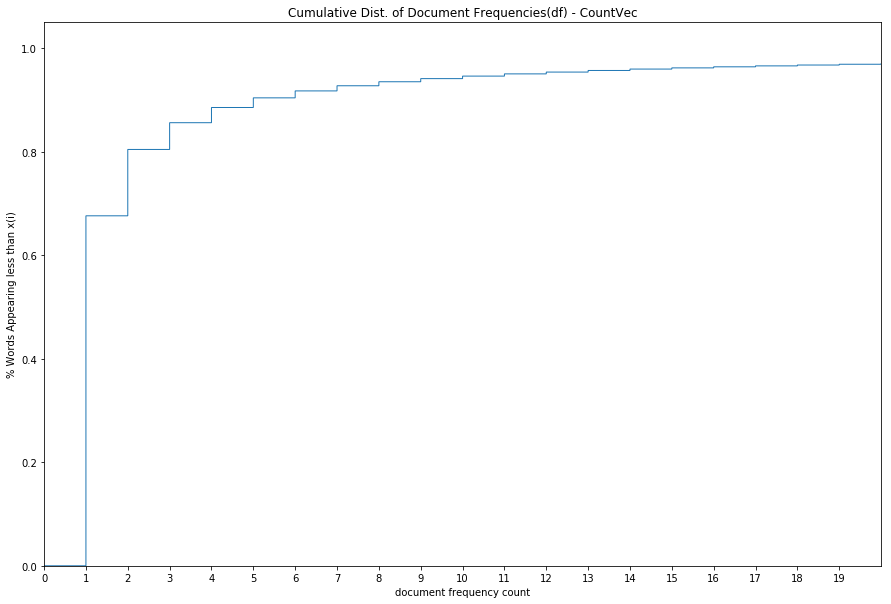

In [16]:
words = list((X_all_C>0).sum(axis=0).tolist()[0])

fig, ax = plt.subplots(figsize=(15,10))
bins = np.arange(sum(words))
plt.hist(words, bins=bins, histtype='step', density=True, cumulative=True)
plt.xlim(0,20)
plt.xticks([x for x in range(0,20,1)])
plt.xlabel('document frequency count')
plt.ylabel('% Words Appearing less than x(i)')
plt.title('Cumulative Dist. of Document Frequencies(df) - CountVec')
plt.show()

In [17]:
best_df = None
best_auc = -np.inf
best_f1 = None
pos_df = [.0001, .001, .01, .1, 1]

for min_df in pos_df:
    vect = CountVectorizer(min_df=min_df, ngram_range=(1, 2)) 
    
    X = vect.fit_transform(beer_overall.clean_text_lem.apply(str))
    X = X.tocsc() 
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_overall, random_state=17)
    
    nb = MultinomialNB(alpha=1, fit_prior=True)
    nb.fit(Xtrain, ytrain)
    y_pred_count = nb.predict(Xtest)
    f1 = metrics.f1_score(ytest, y_pred_count)
    y_prob_count = nb.predict_proba(Xtest)[:,1]
    auc = metrics.roc_auc_score(ytest, y_prob_count)
    if auc > best_auc:
        best_auc = auc
        best_df = min_df
        best_f1 = f1

print('\n Best Values: \n Min_df: {}, F1: {}, AUC: {}'.format(best_df, best_auc, best_f1))


 Best Values: 
 Min_df: 0.0001, F1: 0.8543327265339999, AUC: 0.8212088903469205


In [18]:
best_df = None
best_auc = -np.inf
best_f1 = None
pos_df = [.0001, .001, .01, .1, 1]

for min_df in pos_df:
    vect = TfidfVectorizer(min_df=min_df, ngram_range=(1, 2)) 
    
    X = vect.fit_transform(beer_overall.clean_text_lem.apply(str))
    X = X.tocsc() 
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_overall, random_state=17)
    
    nb = MultinomialNB(alpha=1, fit_prior=True)
    nb.fit(Xtrain, ytrain)
    y_pred_count = nb.predict(Xtest)
    f1 = metrics.f1_score(ytest, y_pred_count)
    y_prob_count = nb.predict_proba(Xtest)[:,1]
    auc = metrics.roc_auc_score(ytest, y_prob_count)
    if auc > best_auc:
        best_auc = auc
        best_df = min_df
        best_f1 = f1

print('\n Best Values: \n Min_df: {}, F1: {}, AUC: {}'.format(best_df, best_auc, best_f1))


 Best Values: 
 Min_df: 0.0001, F1: 0.8595300325275933, AUC: 0.8360847720146575


min_df for both vectorizers works best at .0001. Let's now look at more parameters.

__GridSearchCV:__

In [19]:
# Instantiate Vectorizers with new min_df 
vect = CountVectorizer(min_df=.0001, ngram_range=(1, 2)) 
tfidf_vect = TfidfVectorizer(min_df=.0001, ngram_range=(1, 2))

# Apply CountVectorizer 
X_all_C = vect.fit_transform(beer_overall.clean_text_lem.apply(str))
X_all_C = X_all_C.tocsc() 

# Apply TfidfVectorizer
X_all_idf = tfidf_vect.fit_transform(beer_overall.clean_text_lem.apply(str))
X_all_idf = X_all_idf.tocsc() 

# Split train/test data for all data
# This is for CountVectorizer
Xtrain_all_C, Xtest_all_C, ytrain_all_C, ytest_all_C = train_test_split(X_all_C, y_overall, random_state=17)

# This is for Tfidf Vectorizer
Xtrain_all_idf, Xtest_all_idf, ytrain_all_idf, ytest_all_idf = train_test_split(X_all_idf, y_overall, random_state=17)

In [20]:
# Create a list of parameters for tuning
parameters = {'fit_prior': (True, False),
              'alpha': (0.001, 0.01, 0.1, 1, 5, 10),
             }

In [21]:
# Perform GridSearch on Naive Bayes using the given parameters and CountVectorizer
gs_count_all = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', n_jobs=-1, cv=5)
gs_count_all.fit(Xtrain_all_C, ytrain_all_C)

# Show the best score and parameters used
print(gs_count_all)
print('\nBest Score: ', gs_count_all.best_score_)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'fit_prior': (True, False), 'alpha': (0.001, 0.01, 0.1, 1, 5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

Best Score:  0.8528010913890626


In [22]:
# Perform GridSearch on Naive Bayes using the given parameters and TfidfVectorizer
gs_tfidf_all = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', n_jobs=-1, cv=5)
gs_tfidf_all.fit(Xtrain_all_idf, ytrain_all_idf)

# Show the best score and parameters used
print(gs_tfidf_all)
print('\nBest Score: ', gs_tfidf_all.best_score_)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'fit_prior': (True, False), 'alpha': (0.001, 0.01, 0.1, 1, 5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

Best Score:  0.8567292195676448


In [23]:
# Calculate predicted probabilities for Xtest1
y_prob_nb = gs_tfidf_all.predict_proba(Xtest_all_idf)[:,1]

# Calculate AUC for Naive Bayes model with CountVec
auc = metrics.roc_auc_score(ytest_all_idf, y_prob_nb)

print('AUC: ', auc)

AUC:  0.8592639577707916


__Interpretation:__

The Naive Bayes model using a minimum document frequency of .0001 performs well when using lemmatized tokens. GridSearchCV indicated that the best parameters were the default ones. For further algorithms I will continue to use the TfidfVectorizer because it provided slightly better results. 

Next I will look further into the text to further improve the model amongst other algorithms and classifiers.

***
### Examine text
__Look at False Negatives and False Positives__

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_overall, y_overall, random_state=17)

In [25]:
y_pred_gstfidf = gs_tfidf_all.predict(Xtest_all_idf)

fp = X_test[ytest_all_idf < y_pred_gstfidf]
fn = X_test[ytest_all_idf > y_pred_gstfidf]

1. False Positives

In [26]:
print(fp[0:5])

40935    hazy amber color cotton candy apple nose tobac...
74219    dark brown color beige head aroma sweet malt b...
60307    bottle pour ruby thin head roasted malt aroma ...
56063    oz bottle pour light golden amber light tan wi...
71139    draught brewpubre amber color twin sister iris...
Name: clean_text_lem, dtype: object


In [27]:
print(beer_overall.text[40935], '\n', 'Predicted Prob: ',
      gs_tfidf_all.predict_proba(tfidf_vect.transform([beer_overall.clean_text_lem[40935]])), '\n')
print(beer_overall.text[74219], '\n', 'Predicted Prob: ',
      gs_tfidf_all.predict_proba(tfidf_vect.transform([beer_overall.clean_text_lem[74219]])), '\n')
print(beer_overall.text[60307], '\n', 'Predicted Prob: ',
      gs_tfidf_all.predict_proba(tfidf_vect.transform([beer_overall.clean_text_lem[60307]])), '\n')
print(beer_overall.text[56063], '\n', 'Predicted Prob: ',
      gs_tfidf_all.predict_proba(tfidf_vect.transform([beer_overall.clean_text_lem[56063]])), '\n')
print(beer_overall.text[71139], '\n', 'Predicted Prob: ',
      gs_tfidf_all.predict_proba(tfidf_vect.transform([beer_overall.clean_text_lem[71139]])))

Hazy amber color, cotton candy and apples in the nose. Tobacco, apples, slightly sour mouth. Flowery dry finish. 
 Predicted Prob:  [[0.35494527 0.64505473]] 

Dark brown in color with a beige head. Aroma is of sweet malt, brown sugar, and chocolate. Taste is of chocolate and toffee. 
 Predicted Prob:  [[0.10028479 0.89971521]] 

Bottle...  Poured ruby with a thin head.  Roasted malt aroma.  Highly carbonated, with flavors caramel hops and malt to balance. Has a full body and the flavors are really amped.  Chalky aftertaste. 
 Predicted Prob:  [[0.21189355 0.78810645]] 

22 oz bottle.  Pours a light golden amber with a light off tan wispy head. Heavy hop nose with a slightly sweet smell. Medium body. Good hop taste not overpowering, a good balance with the malt flavor. 
 Predicted Prob:  [[0.24313403 0.75686597]] 

Draught at the brewpubRed amber color. Its the twin sister of the Irish Honey Ale, but mellower, sweeter, more perfumy (so far, better) and a light breadish character. 
 Pre

2. False Negatives

In [28]:
print(fn[0:5])

4491     dark amber colour nice beige head spicy aroma ...
25737    bottle grslstasting pour clear copper colour t...
68900    bottle trade clevar pour slightly hazy orangis...
59597    wonderful bready grainy nutty aroma light gole...
24416    ml bottle brewery hazy reddish orange pinkyish...
Name: clean_text_lem, dtype: object


In [29]:
print(beer_overall.text[4491], '\n', 'Predicted Prob: ',
      gs_tfidf_all.predict_proba(tfidf_vect.transform([beer_overall.clean_text_lem[4491]])), '\n')
print(beer_overall.text[25737], '\n', 'Predicted Prob: ',
      gs_tfidf_all.predict_proba(tfidf_vect.transform([beer_overall.clean_text_lem[25737]])), '\n')
print(beer_overall.text[68900], '\n', 'Predicted Prob: ',
      gs_tfidf_all.predict_proba(tfidf_vect.transform([beer_overall.clean_text_lem[68900]])), '\n')
print(beer_overall.text[59597], '\n', 'Predicted Prob: ',
      gs_tfidf_all.predict_proba(tfidf_vect.transform([beer_overall.clean_text_lem[59597]])), '\n')
print(beer_overall.text[24416], '\n', 'Predicted Prob: ',
      gs_tfidf_all.predict_proba(tfidf_vect.transform([beer_overall.clean_text_lem[24416]])))

Dark amber coloured. Nice beige head. Spicy aroma of primarily corriander. Flavour of caramel, ligth citrus and some alcahol burn. Not much aftertaste, but a decent beer though. 
 Predicted Prob:  [[0.51526669 0.48473331]] 

Bottle at Grslstasting. Poured clear copper colour with thin white head. Crisp grassy aroma. Flavour is grassy and a bit sweet. Very well balanced. Bitter finish. 
 Predicted Prob:  [[0.80864077 0.19135923]] 

Bottle from a trade from CLevar. Pours slightly hazy orangish color with off white head. Floral and grassy hop aroma with some caramel.  Lightly sweet caramel flavor with some hop bitterness. Medium body with average carbonation. Thanks Caleb, 
 Predicted Prob:  [[0.51449196 0.48550804]] 

Wonderful bready, grainy, nutty aroma.  Light goledn appearance, but MUCH more flavor than it looks to have.  Rich and yeasty/bready, I can alomst taste the oats.  Full aftertaste with a hint of warmth going down.  Overall a wonderful lighter beer. 
 Predicted Prob:  [[0.59

If you look at each of the reviews up above that were incorrectly considered a "high" overall rating beer, you will notice that they are very neutral and objective. For reviews like these it is harder to gain a precise prediction.

The same can be said for the false negatives. They are most likely on the cusp of the 3.5 separation I made for the high and low ratings.

Next before applying different classifiers I want to see if creating a model for a subset of the beers, in this case IPAs, will create a better model.

### IPA Naive Bayes


In [30]:
# Store overall beer dataset into feature matrix and response vector
X_ipa = ipa['clean_text_lem']
y_ipa = (ipa.high_low == 'high').values.astype(np.int)

In [31]:
best_df = None
best_auc = -np.inf
best_f1 = None
pos_df = [.0001, .001, .01, .1, 1]

for min_df in pos_df:
    vect = CountVectorizer(min_df=min_df, ngram_range=(1, 2))
    
    X = vect.fit_transform(ipa.clean_text_lem.apply(str))
    X = X.tocsc() 
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_ipa, random_state=17)
    
    nb = MultinomialNB(alpha=1, fit_prior=True)
    nb.fit(Xtrain, ytrain)
    y_pred_count = nb.predict(Xtest)
    f1 = metrics.f1_score(ytest, y_pred_count)
    y_prob_count = nb.predict_proba(Xtest)[:,1]
    auc = metrics.roc_auc_score(ytest, y_prob_count)
    if auc > best_auc:
        best_auc = auc
        best_df = min_df
        best_f1 = f1

print('\n Best Values: \n Min_df: {}, F1: {}, AUC: {}'.format(best_df, best_auc, best_f1))


 Best Values: 
 Min_df: 0.001, F1: 0.8101679929266136, AUC: 0.8374011687865245


In [32]:
best_df = None
best_auc = -np.inf
best_f1 = None
pos_df = [.0001, .001, .01, .1, 1]

for min_df in pos_df:
    vect = TfidfVectorizer(min_df=min_df, ngram_range=(1, 2)) 
    
    X = vect.fit_transform(ipa.clean_text_lem.apply(str))
    X = X.tocsc() 
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_ipa, random_state=17)
    
    nb = MultinomialNB(alpha=1, fit_prior=True)
    nb.fit(Xtrain, ytrain)
    y_pred_count = nb.predict(Xtest)
    f1 = metrics.f1_score(ytest, y_pred_count)
    y_prob_count = nb.predict_proba(Xtest)[:,1]
    auc = metrics.roc_auc_score(ytest, y_prob_count)
    if auc > best_auc:
        best_auc = auc
        best_df = min_df
        best_f1 = f1

print('\n Best Values: \n Min_df: {}, F1: {}, AUC: {}'.format(best_df, best_auc, best_f1))


 Best Values: 
 Min_df: 0.001, F1: 0.8066454465075155, AUC: 0.8456336371655395


In [33]:
# Store overall beer dataset into feature matrix and response vector
X_ipa = ipa['clean_text_lem']
y_ipa = (ipa.high_low == 'high').values.astype(np.int)

# Instantiate CountVectorizer and TfidfVectorizer
vect = CountVectorizer(min_df=.001, ngram_range=(1, 2)) 
tfidf_vect = TfidfVectorizer(min_df=.001, ngram_range=(1, 2))


# Apply CountVectorizer 
X_ipa_C = vect.fit_transform(ipa.clean_text_lem.apply(str))
X_ipa_C = X_ipa_C.tocsc() 

# Apply TfidfVectorizer
X_ipa_idf = tfidf_vect.fit_transform(ipa.clean_text_lem.apply(str))
X_ipa_idf = X_ipa_idf.tocsc() 


# Split train/test data for all data
# This is for CountVectorizer
Xtrain_ipa_C, Xtest_ipa_C, ytrain_ipa_C, ytest_ipa_C = train_test_split(X_ipa_C, y_ipa, random_state=17)

# This is for Tfidf Vectorizer
Xtrain_ipa_idf, Xtest_ipa_idf, ytrain_ipa_idf, ytest_ipa_idf = train_test_split(X_ipa_idf, y_ipa, random_state=17)

In [34]:
# Instantiate MultinomialNB() for CountVectorizer
nb_ipa = MultinomialNB(alpha=1, fit_prior=True)

# Train model
nb_ipa.fit(Xtrain_ipa_C, ytrain_ipa_C)

# Make predictions for Xtest
y_pred_count = nb_ipa.predict(Xtest_ipa_C)

# Calculate F1 Score
f1 = metrics.f1_score(ytest_ipa_C, y_pred_count)

# Confusion matrix
cm = metrics.confusion_matrix(ytest_ipa_C, y_pred_count)

# Calculate predicted probabilities for Xtest
y_prob_count = nb_ipa.predict_proba(Xtest_ipa_C)[:,1]

# Calculate AUC for Naive Bayes model with CountVec
auc = metrics.roc_auc_score(ytest_ipa_C, y_prob_count)

print(vect)
print('\nF1 Score: ', f1)
print('\nConfusion Matrix:\n', cm)
print('\nAUC: ', auc)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.001,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

F1 Score:  0.8374011687865245

Confusion Matrix:
 [[ 344  241]
 [ 232 1218]]

AUC:  0.8101679929266136


In [35]:
# Instantiate multinomialNB() for TfidfVectorizer
nb_tfidf_ipa = MultinomialNB(alpha=1, fit_prior=True)

# Train model
nb_tfidf_ipa.fit(Xtrain_ipa_idf, ytrain_ipa_idf)

# Make predictions for Xtest1
y_pred_tfidf = nb_tfidf_ipa.predict(Xtest_ipa_idf)

# Calculate F1 Score
f1 = metrics.f1_score(ytest_ipa_idf, y_pred_tfidf)

# Confusion matrix
cm = metrics.confusion_matrix(ytest_ipa_idf, y_pred_tfidf)

# Calculate predicted probabilities for Xtest1
y_prob_tfidf = nb_tfidf_ipa.predict_proba(Xtest_ipa_idf)[:,1]

# Calculate AUC for Naive Bayes model with Tfidf
auc = metrics.roc_auc_score(ytest_ipa_idf, y_prob_tfidf)

print(tfidf_vect)
print('\nF1 Score: ', f1)
print('\nConfusion Matrix:\n', cm)
print('\nAUC: ', auc)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.001,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

F1 Score:  0.8456336371655395

Confusion Matrix:
 [[  72  513]
 [  12 1438]]

AUC:  0.8066454465075155


In [36]:
# Perform GridSearch on Naive Bayes using the given parameters and CountVectorizer
gs_count_ipa = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', n_jobs=-1, cv=5)
gs_count_ipa.fit(Xtrain_ipa_C, ytrain_ipa_C)

# Show the best score and parameters used
print(gs_count_ipa)
print('\nBest Score: ', gs_count_ipa.best_score_)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'fit_prior': (True, False), 'alpha': (0.001, 0.01, 0.1, 1, 5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

Best Score:  0.7995704448127914


In [37]:
# Perform GridSearch on Naive Bayes using the given parameters and TfidfVectorizer
gs_tfidf_ipa = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', n_jobs=-1, cv=5)
gs_tfidf_ipa.fit(Xtrain_ipa_idf, ytrain_ipa_idf)

# Show the best score and parameters used
print(gs_tfidf_ipa)
print('\nBest Score: ', gs_tfidf_ipa.best_score_)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'fit_prior': (True, False), 'alpha': (0.001, 0.01, 0.1, 1, 5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

Best Score:  0.7904826909160307


### Compare Models. Does IPA Naive Bayes model work better on overall dataset?

In [38]:
gs_tfidf_ipa.fit(Xtrain_all_idf, ytrain_all_idf)
# Show the best score and parameters used
print(gs_tfidf_ipa)
print('\nBest Score: ', gs_tfidf_ipa.best_score_)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'fit_prior': (True, False), 'alpha': (0.001, 0.01, 0.1, 1, 5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

Best Score:  0.8567292195676448


In [39]:
gs_tfidf_all_ipa = gs_tfidf_all
gs_tfidf_all_ipa.fit(Xtrain_ipa_idf, ytrain_ipa_idf)
print(gs_tfidf_all_ipa)
print('\nBest Score: ', gs_tfidf_all_ipa.best_score_)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'fit_prior': (True, False), 'alpha': (0.001, 0.01, 0.1, 1, 5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

Best Score:  0.7904826909160307


Does not create a better result using the IPA model. 

To conclude using Naive Bayes, when looking at the entire dataset a TFIDF Vectorizer worked best with standard parameters. The area under the curve came out to be 0.8567292195676448. This can be seen in the graph below.

Moving forward I will use the split data using the TFIDF Vectorizer with different classifiers.

***

## Experiment with Other Classifiers 
### 1. Logistic Regression

In [40]:
# Instantiate and fit training data to Logistic Regression Model
log_clf = LogisticRegressionCV(scoring='roc_auc', class_weight='balanced', cv=5, max_iter=1000).fit(Xtrain_all_idf, 
                                                                                                    ytrain_all_idf)
# Predict ratings for Logistic Regression Model
pred_log_clf = log_clf.predict(Xtest_all_idf)

# Calculate F1 Score
metrics.f1_score(ytest_all_idf, pred_log_clf)

0.8282099149554034

In [41]:
log_clf

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=1000,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring='roc_auc',
           solver='lbfgs', tol=0.0001, verbose=0)

In [224]:
# Calculate Predicted Probabilities
pred_prob_log_clf = log_clf.predict_proba(Xtest_all_idf)[:,1]

In [43]:
# Determine ROC Score
metrics.roc_auc_score(ytest_all_idf, pred_prob_log_clf)

0.8733554720786474

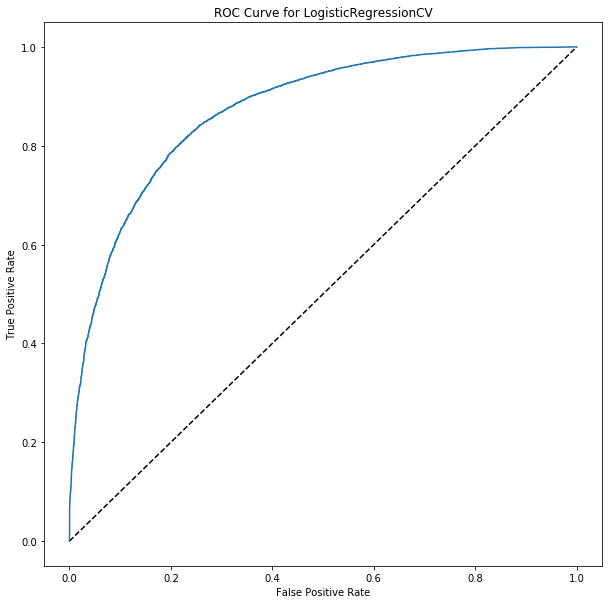

In [44]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(ytest_all_idf, pred_prob_log_clf)

# Plot ROC curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegressionCV')
plt.show()

***
### 2. Random Forests

In [126]:
# Instantiate and fit Random Forests Model
randofor_clf = RandomForestClassifier(class_weight='balanced',
                                     n_estimators=100).fit(Xtrain_all_idf, ytrain_all_idf)

# Predict Ratings using Random Forests Model
pred_randofor_clf = randofor_clf.predict(Xtest_all_idf)

# Calculate F1 Score
metrics.f1_score(ytest_all_idf, pred_randofor_clf)

0.8339733110291603

In [127]:
parameters = {'max_features': [500, 600, 700, 800],
              'min_samples_leaf': (5,6,7,8,9),
              }

In [128]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced', n_estimators=100), 
                     parameters, scoring='roc_auc', n_jobs=-1, cv=5)
gs_rf.fit(Xtrain_all_idf, ytrain_all_idf)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': [500, 600, 700, 800], 'min_samples_leaf': (5, 6, 7, 8, 9)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [129]:
gs_rf

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': [500, 600, 700, 800], 'min_samples_leaf': (5, 6, 7, 8, 9)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [130]:
# Get best parameters and best accuracy score
print('Best Score: ', gs_rf.best_score_)
print('Best Parameters: ', gs_rf.best_params_)

Best Score:  0.8467779669624498
Best Parameters:  {'max_features': 500, 'min_samples_leaf': 5}


In [131]:
# calculate predicted probabilities
pred_prob_randofor_clf = gs_rf.predict_proba(Xtest_all_idf)[:, 1]

In [132]:
# Determine ROC score
metrics.roc_auc_score(ytest_all_idf, pred_prob_randofor_clf)

0.8513179077939098

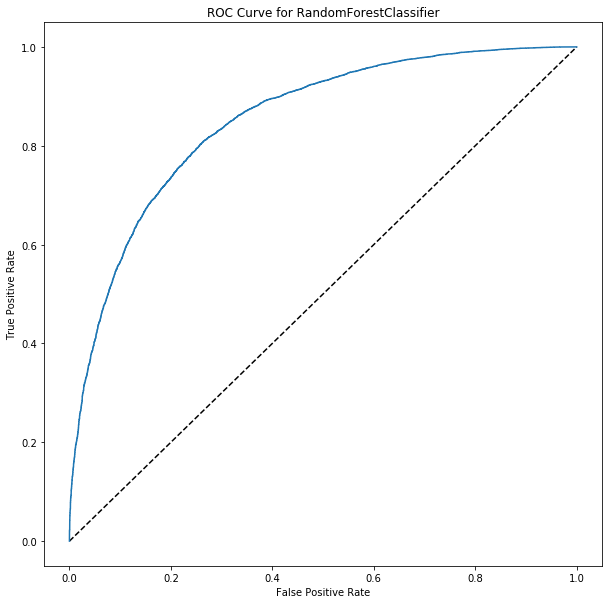

In [133]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(ytest_all_idf, pred_prob_randofor_clf)

# Plot ROC curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForestClassifier')
plt.show()

***
### 3. Support Vector Machines

In [120]:
# Instantinate and Train SVM model
svm_clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability=True)
svm_clf.fit(Xtrain_all_idf, ytrain_all_idf)

# Predict ratings using SVM model
pred_svm = svm_clf.predict(Xtest_all_idf)

# Calculate F1 Score
metrics.f1_score(ytest_all_idf, pred_svm)

0.8387377068604606

In [121]:
# Calculate Predicted Probabiliites for SVM model
pred_prob_svm_clf = svm_clf.predict_proba(Xtest_all_idf)[:, 1]

In [122]:
# Generate ROC Score
metrics.roc_auc_score(ytest_all_idf, pred_prob_svm_clf)

0.8684223780553382

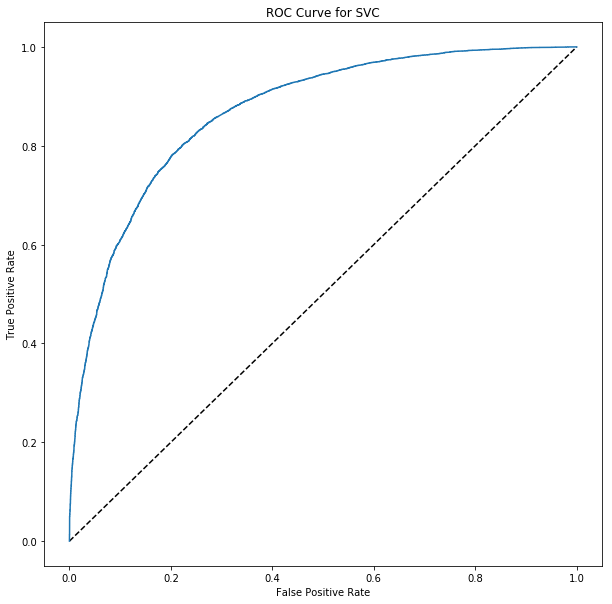

In [124]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(ytest_all_idf, pred_prob_svm_clf)

# Plot ROC curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVC')
plt.show()

***
## Examine Predicted Probabilities of Best Model
The best model was LogisticRegressionCV. Let's examine the predicted probabilities for this model.  

In [45]:
# Create and print the confusion matrix for the LogReg Model
confusion_logreg = metrics.confusion_matrix(ytest_all_idf, pred_log_clf)
print(confusion_logreg)

[[6229 1762]
 [2379 9982]]


In [48]:
# Determine the false positives and false negatives based off the predictions made using LogisticRegressionCV
fp = X_test[ytest_all_idf < pred_log_clf]
fn = X_test[ytest_all_idf > pred_log_clf]

# Determine predicted probabilites for false positives and false negatives
a = pred_prob_log_clf[ytest_all_idf < pred_log_clf]
b = pred_prob_log_clf[ytest_all_idf > pred_log_clf]

# Convert false negative and false positives from series to data frame
fp = fp.to_frame()
fn = fn.to_frame()

# Add Predictive Probabilities as a Column
fp['pred_prob'] = a
fn['pred_prob'] = b

# Sort by Predictive Probabilities
fp = fp.sort_values(by=['pred_prob'], ascending=False)
fn = fn.sort_values(by=['pred_prob'] )

1. False Positives - When the rating was low but predicted as high

In [49]:
# Print the first five false positives
print(fp[0:5])

                                          clean_text_lem  pred_prob
67135  oz bottle bevmo pour yellowish color pure whit...   0.995780
61414  fruity sweet smell nice foamy head good malt d...   0.993783
2222   amber color good balance sweet malty aroma nic...   0.989848
62141  bomber nice hazy look smell hoppy taste nicely...   0.978987
57381  oz bottle pour golden amber solid head aroma c...   0.978267


In [50]:
# Print the full text of the false positives along with its predicted probability
print(beer_overall.text[67135], '\n', 'Predicted Probability: ', fp.pred_prob.iloc[0], '\n')
print(beer_overall.text[61414], '\n', 'Predicted Probability: ', fp.pred_prob.iloc[1], '\n')
print(beer_overall.text[2222], '\n', 'Predicted Probability: ', fp.pred_prob.iloc[2], '\n')
print(beer_overall.text[62141], '\n', 'Predicted Probability: ', fp.pred_prob.iloc[3], '\n')
print(beer_overall.text[57381], '\n', 'Predicted Probability: ', fp.pred_prob.iloc[4], '\n')

22oz bottle from Bevmo.  Pours a yellowish color with a pure white, fluffy head. Piney citrus aroma. Nice toasty malt flavors behind some citrus hop flavors. Very floral in the finish. Really nice and drinkable, this one has some good character, and hides the alcohol well. A very solid, tasty brew. 
 Predicted Probability:  0.9957798169941683 

fruity sweet smell with a nice foamy head. good malt with a dry hoppy finish good balance alcohol is well hidden 
 Predicted Probability:  0.9937825710884449 

Amber in color, good balance, sweet malty aroma, nice lacy head, very well balanced, excellent hoppiness to the beer then the malty sweetness flavors took over, all around great beer 
 Predicted Probability:  0.9898480242936349 

From bomber. Nice hazy look to it, smells hoppy, tastes nicely fruity and with a nice hop backbone. Very well balanced and hides the alcohol. 		good stuff. 
 Predicted Probability:  0.9789871606622387 

22 oz bottle. Poured a golden amber, with a solid head. Arom

Look at the extreme false positives it appears that there could be a variety of things causing this to occur. The first, these reviewers are harsh and an overall beer falls to them as a 3 star rating. I may need to change my binary 'high', 'low' rating to adjust for this.

Second, for the most part, the content of the review is describing the beer and its qualities with a few positive words added in as part of that description. These words may be insinuating a more positive review than it actually is.

2. False Negatives - When the rating was high but predicted as low

In [51]:
# Print the first five false negatives
print(fn[0:5])

                                          clean_text_lem  pred_prob
36260  tap brewpub pour clear pale yellow minimal wis...   0.004538
4757                                     nothing special   0.005078
55204  ml bottle look part aroma mild flavour one dim...   0.005502
51057  draught pour red amber thin white head weak su...   0.005607
60155  not great beer not terrible would not buy expe...   0.008396


In [52]:
# Print the full text of the false negatives along with its predicted probability
print(beer_overall.text[36260], '\n', 'Predicted Probability: ', fn.pred_prob.iloc[0], '\n')
print(beer_overall.text[4757], '\n', 'Predicted Probability: ', fn.pred_prob.iloc[1], '\n')
print(beer_overall.text[55204], '\n', 'Predicted Probability: ', fn.pred_prob.iloc[2], '\n')
print(beer_overall.text[51057], '\n', 'Predicted Probability: ', fn.pred_prob.iloc[3], '\n')
print(beer_overall.text[60155], '\n', 'Predicted Probability: ', fn.pred_prob.iloc[4], '\n')

On tap, at brewpub.  Pours a clear pale yellow with a minimal wispy white head, light visible carbonation.  Light but clean pale malt nose, no corn noticeable with minimal to no hops.  The flavors a bit grassy and has a touch of corn, but its still pretty clean.  The mouth feel is light bodied and fizzy wth fizzy spritzy carbonation.  Not bad for what it is. 
 Predicted Probability:  0.004537897704474279 

Nothing special. 
 Predicted Probability:  0.005077654695533623 

650 mL bottle.  Looks the part, but the aroma is mild, and the flavour is one-dimensional.  Not enough roast and too much soya sauce.  Not bad, really.  Just a little disappointing. 
 Predicted Probability:  0.005501506079379048 

Draught. Pours red amber with a thin off white head. Weak sugary malt and hop aroma. Flavor is more sweet, sugary malt with a touch of hops. Overall somewhat bland. Nothing offensive but nothing wooing me over. 
 Predicted Probability:  0.0056066828511128226 

Not a great beer at all, not ter

Vice versa, these reviewers may be easy going and often than not provide higher reviews. It appears their reviews give a similar tone of nothing special but nothing poor. However, just like the positive reviews, these reviews appear to have certain negative words such as 'nothing' and 'bad' that may make it appear that the sentiment is lower than it actually is. 

Looking at the predicted probabilities you see that the classifier may not be at the best threshold. I will try to adjust this next

***
## Thresholding for Different Business Cases 
#### 1. Accuracy - Sometimes you want to most accurate predictions. In this model I will try to get the least number of false positives and false negatives.

The default threshold is 0.5. I am going to examine different levels to see if I can determine a better threshold.

For the first business case, I am looking at accuracy and confusion matrices to determine the best threshold to have the best accuracy and least number of false positives and false negatives. 

In [275]:
def adjust_pred_prob(y_pred_prob, new_threshold):
    """Adjust predicted probabilities to match new threshold value"""
    
    return [1 if y >= new_threshold else 0 for y in y_pred_prob]

In [276]:
# Calculate balanced accuracy
balanced_accuracy_score(ytest_all_idf, pred_log_clf)

0.7935208913684557

In [287]:
thresholds=np.arange(0,1,.01)

In [289]:
accuracy_points = []

for t in thresholds:
        adjusted_y_pred = adjust_pred_prob(pred_prob_log_clf, new_threshold=t)
        new_balance = accuracy_score(ytest_all_idf, adjusted_y_pred)
        accuracy_points.append(new_balance)

In [290]:
balanced_accuracy_points = []

for t in thresholds:
        adjusted_y_pred = adjust_pred_prob(pred_prob_log_clf, new_threshold=t)
        new_balance = balanced_accuracy_score(ytest_all_idf, adjusted_y_pred)
        balanced_accuracy_points.append(new_balance)

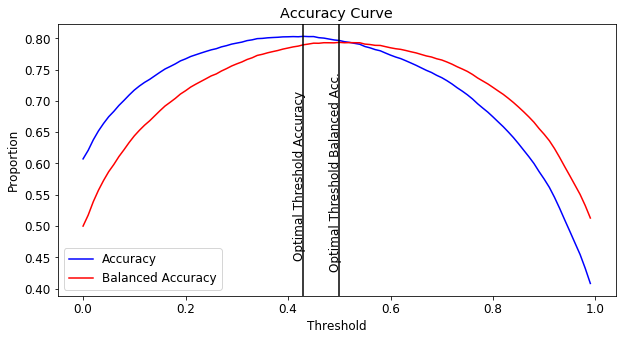

In [291]:
plt.figure(figsize=(10,5))
plt.plot(thresholds, accuracy_points, color='blue')
plt.plot(thresholds, balanced_accuracy_points, color='red')
plt.title('Accuracy Curve')
plt.legend(('Accuracy', 'Balanced Accuracy'))
plt.xlabel('Threshold')
plt.axvline(x=.43, color='black')
plt.text(.41,.7,'Optimal Threshold Accuracy',rotation=90)
plt.axvline(x=.5, color='black')
plt.text(.48,.73,'Optimal Threshold Balanced Acc.',rotation=90)
plt.ylabel('Proportion')
plt.show()

In [303]:
print('Highest Accuracy: ', accuracy_points[43])
adjusted_y_pred = adjust_pred_prob(pred_prob_log_clf, new_threshold=.43)
print(metrics.confusion_matrix(ytest_all_idf, adjusted_y_pred))

print('\nHighest Balanced Accuracy: ', balanced_accuracy_points[50])
adjusted_y_pred = adjust_pred_prob(pred_prob_log_clf, new_threshold=.5)
print(metrics.confusion_matrix(ytest_all_idf, adjusted_y_pred))

Highest Accuracy:  0.8031151729559748
[[ 5808  2183]
 [ 1824 10537]]

Highest Balanced Accuracy:  0.7935208913684557
[[6229 1762]
 [2379 9982]]


When you're trying to apply the model on new comments, reviews, etc. on other websites and/or social media, you want the predictor to be as accurate as possible. To determine this I gauged the model using accuracy and confusion matrices. I wanted the least number of mispredictions (false negatives, false positives). The threshold level of 0.43 provides the best results with an accuracy of 0.803. In total there are 4007 mispredictions, 1824 false negatives and 2183 false positives.

However, a point of emphasis to be made is that balanced accuracy is a more appropriate metric for this because the data is unbalanced. For this reason if you'd like a predictor that overall performs better based on the unbalanced data, you should stick to the 0.5 threshold. 

#### 2. Looking at a specific set of outcomes. In this case, let's say you are wondering if you need to increase your customer support staff and you'd like to look at the low reviews. You'd want to predict the most correct "low" overall ratings without increasing the number of mispredictions for "high" ratings. 

I want to optimize the threshold to optimize "low" ratings. I will focus on the f1 score metric to do so. 

In [368]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold, label):
    adjusted_y_pred = adjust_pred_prob(pred_prob_log_clf, new_threshold=threshold) 
    print('F1 Score: ', metrics.f1_score(ytest_all_idf, adjusted_y_pred, pos_label= label))
    print(metrics.classification_report(ytest_all_idf, adjusted_y_pred))

In [390]:
evaluate_threshold(.53, 0)

F1 Score:  0.7506623491315867
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      7991
           1       0.86      0.79      0.82     12361

   micro avg       0.79      0.79      0.79     20352
   macro avg       0.78      0.79      0.79     20352
weighted avg       0.80      0.79      0.79     20352



In [388]:
evaluate_threshold(.54, 0)

F1 Score:  0.7508472595535819
              precision    recall  f1-score   support

           0       0.70      0.80      0.75      7991
           1       0.86      0.78      0.82     12361

   micro avg       0.79      0.79      0.79     20352
   macro avg       0.78      0.79      0.79     20352
weighted avg       0.80      0.79      0.79     20352



In [389]:
evaluate_threshold(.55, 0)

F1 Score:  0.748739933955159
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      7991
           1       0.86      0.77      0.81     12361

   micro avg       0.79      0.79      0.79     20352
   macro avg       0.78      0.79      0.78     20352
weighted avg       0.80      0.79      0.79     20352



What would it be if the situation was the other way around? You want to focus on "high" overall rated reviews. Let's determine the optimal threshold for this.

In [383]:
evaluate_threshold(.33, 1)

F1 Score:  0.8441165342413923
              precision    recall  f1-score   support

           0       0.81      0.64      0.71      7991
           1       0.79      0.90      0.84     12361

   micro avg       0.80      0.80      0.80     20352
   macro avg       0.80      0.77      0.78     20352
weighted avg       0.80      0.80      0.79     20352



In [384]:
evaluate_threshold(.34, 1)

F1 Score:  0.8446457801971906
              precision    recall  f1-score   support

           0       0.80      0.65      0.72      7991
           1       0.80      0.90      0.84     12361

   micro avg       0.80      0.80      0.80     20352
   macro avg       0.80      0.77      0.78     20352
weighted avg       0.80      0.80      0.79     20352



In [385]:
evaluate_threshold(.35, 1)

F1 Score:  0.8442149550583286
              precision    recall  f1-score   support

           0       0.80      0.66      0.72      7991
           1       0.80      0.89      0.84     12361

   micro avg       0.80      0.80      0.80     20352
   macro avg       0.80      0.77      0.78     20352
weighted avg       0.80      0.80      0.80     20352



Now let's plot all our of our business models into one plot with the f1 score, precision and recall curves.

In [304]:
# Calculate Precision and Recall Curve
precision, recall, thresholds = precision_recall_curve(ytest_all_idf, pred_prob_log_clf)
thresholds = np.append(thresholds, 1)

In [305]:
# Calculate F1 Score Curve
f1_points = []

for t in thresholds:
        adjusted_y_pred = adjust_pred_prob(pred_prob_log_clf, new_threshold=t)
        new_f1 = metrics.f1_score(ytest_all_idf, adjusted_y_pred)
        f1_points.append(new_f1)

C:\Users\soham\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


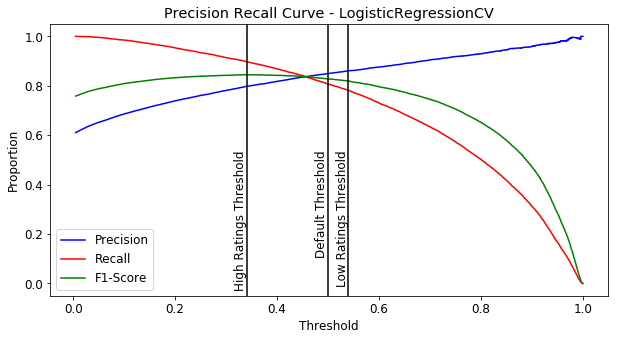

In [401]:
# Plot Balanced Accuracy, Accuracy, Precision, Recall and F1 Score on a graph together.

plt.figure(figsize=(10,5))
plt.plot(thresholds, precision, color='blue')
plt.plot(thresholds, recall, color='red')
plt.plot(thresholds, f1_points, color='green')
plt.title('Precision Recall Curve - LogisticRegressionCV')
plt.legend(('Precision', 'Recall', 'F1-Score'))
plt.xlabel('Threshold')
plt.ylabel('Proportion')
plt.axvline(x=.54, color='black')
plt.text(.515,.50,'Low Ratings Threshold',rotation=90)
plt.axvline(x=.34, color='black')
plt.text(.315,.50,'High Ratings Threshold',rotation=90)
plt.axvline(x=.50, color='black')
plt.text(.475,.50,'Default Threshold',rotation=90)
plt.show()

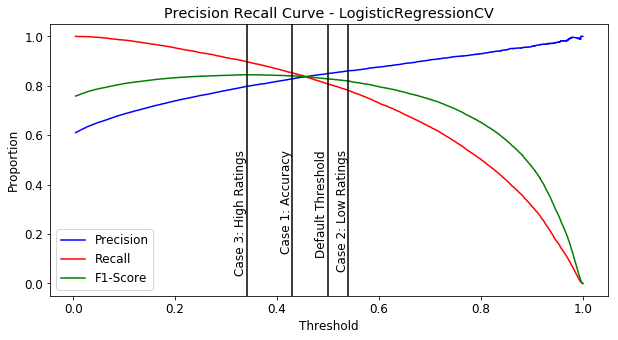

In [399]:
# Plot Balanced Accuracy, Accuracy, Precision, Recall and F1 Score on a graph together.

plt.figure(figsize=(10,5))
plt.plot(thresholds, precision, color='blue')
plt.plot(thresholds, recall, color='red')
plt.plot(thresholds, f1_points, color='green')
plt.title('Precision Recall Curve - LogisticRegressionCV')
plt.legend(('Precision', 'Recall', 'F1-Score'))
plt.xlabel('Threshold')
plt.ylabel('Proportion')
plt.axvline(x=.43, color='black')
plt.text(.405,.50,'Case 1: Accuracy',rotation=90)
plt.axvline(x=.54, color='black')
plt.text(.515,.50,'Case 2: Low Ratings',rotation=90)
plt.axvline(x=.34, color='black')
plt.text(.315,.50,'Case 3: High Ratings',rotation=90)
plt.axvline(x=.50, color='black')
plt.text(.475,.50,'Default Threshold',rotation=90)
plt.show()